In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

N = 100
V = 1
T = 100
LAMBDA = 2
TAU = 1 / LAMBDA
DIRECTION = [0, np.pi * 2]
FRAME_INTERVAL = 0.01 

### Function Definitions

In [2]:
def generate_possion_process(n, rate=1, time=100, sample_size=10000, method=["time", "interval"][0]):
    sample = [[]]
    num_samples = 0
    total_time = 0
    while num_samples < n:
        intervals = np.random.exponential(1.0 / rate, sample_size)
        for interval in intervals: 
            total_time += interval
            if total_time > time:
                if method == "interval":
                    sample[-1].append(time - (total_time - interval))
                    sample.append([])
                num_samples += 1
                if num_samples >= n:
                    break
                if method == "time":
                    sample.append([interval])
                total_time = 0
                continue
            if method == "time":
                sample[-1].append(total_time)
            elif method == "interval":
                sample[-1].append(interval)
    
    return sample

def generate_directions(n):
    return np.random.uniform(DIRECTION[0], DIRECTION[1], n)

def calculate_translation(v, theta, dim_3=False):
    if not dim_3:
        return v * np.stack([np.cos(theta), np.sin(theta)], axis=1)
    else:
        u = np.random.uniform(-1, 1, len(theta))
        return v * np.stack([
            np.sqrt(1 - np.square(u)) * np.cos(theta),
            np.sqrt(1 - np.square(u)) * np.sin(theta),
            u], axis=1)

def calculate_final_position(df: pd.DataFrame, method=["jump", "constant_v"]):
    if method == "jump":
        final_pos_df = df.groupby("id").sum()
    elif method == "constant_v":
        df["x"] = df["t"] * df["x"]
        df["y"] = df["t"] * df["y"]
        final_pos_df = df.groupby("id").sum()
    return final_pos_df 


### Sampling

In [12]:
def random_direction(method=["constant_v", "jump"][0]):
    dfs = []
    samples = generate_possion_process(N, rate=LAMBDA, time=T, method="interval")
    for idx, sample in enumerate(samples):
        pos = calculate_translation(V, generate_directions(len(sample)))
        dfs.append(pd.DataFrame({"x": pos[:, 0], "y": pos[:, 1], "id": idx, "t": sample}))
    df = pd.concat(dfs).sort_values("id").reset_index(drop=True)
    final_pos_df = calculate_final_position(df, method=method)
    return final_pos_df

#### Random tumbling (constant v)

In [13]:
N = 10000
V = 1
T = 100
LAMBDA = 1
TAU = 1 / LAMBDA
DIRECTION = [0, np.pi * 2]

In [14]:
expected = np.square(V) * TAU * T
results = [(np.square(random_direction(method="constant_v")["x"])).mean() for _ in range(10)]
print(f"Var(X) ({N} samples, 10 runs):\nSimulated: {np.mean(results):.2f} \u00b1 {np.std(results):.2f}\nExpected: {expected}")

Var(X) (10000 samples, 10 runs):
Simulated: 98.78 ± 1.67
Expected: 100.0


#### Random tumbling (jumping)

In [15]:
N = 10000
V = 1
T = 100
LAMBDA = 1
TAU = 1 / LAMBDA
DIRECTION = [0, np.pi * 2]

In [16]:
expected = np.square(V) * LAMBDA * T / 2
results = [(np.square(random_direction(method="jump")["x"])).mean() for _ in range(10)]
print(f"Var(X) ({N} samples, 10 runs):\nSimulated: {np.mean(results):.2f} \u00b1 {np.std(results):.2f}\nExpected: {expected}")

Var(X) (10000 samples, 10 runs):
Simulated: 50.77 ± 0.84
Expected: 50.0


### Matplot Animation

In [3]:
TEXT_OFFSET = 0.08
def plot_simulation(df, method=["constant_v", "jump"][0]):
    def constant_v_update(t):
        nonlocal pos
        movement = df[np.isclose(np.round(df["t"], 2), t * FRAME_INTERVAL)]
        for _, row in movement.iterrows():
            sample_idx = int(row["id"])
            move[sample_idx, 0] = row["x"]
            move[sample_idx, 1] = row["y"]
        pos += move * FRAME_INTERVAL
        scat.set_offsets(pos)
        for idx, text in enumerate(texts):
            text.set_position((pos[idx, 0] + TEXT_OFFSET, pos[idx, 1] + TEXT_OFFSET))
        ax.set_title(f"t = {t * FRAME_INTERVAL:.2f}")

    def jump_update(t):
        movement = df[np.isclose(np.round(df["t"], 2), t * FRAME_INTERVAL)]
        for _, row in movement.iterrows():
            sample_idx = int(row["id"])
            pos[sample_idx, 0] += row["x"]
            pos[sample_idx, 1] += row["y"]
        scat.set_offsets(pos)
        for idx, text in enumerate(texts):
            text.set_position((pos[idx, 0] + TEXT_OFFSET, pos[idx, 1] + TEXT_OFFSET))
        ax.set_title(f"t = {t * FRAME_INTERVAL:.2f}")
        return scat, *texts

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.grid(True, ls="--")
    pos = np.zeros((N, 2))
    move = calculate_translation(V, generate_directions(N))
    scat = ax.scatter(pos[:, 0], pos[:, 1], s=5)
    texts = [ax.text(pos[i, 0] + TEXT_OFFSET, pos[i, 1] + TEXT_OFFSET, i, fontsize=5) for i in range(N)]
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

    if method == "jump":
        func = jump_update
    elif method == "constant_v":
        func = constant_v_update

    ani = animation.FuncAnimation(fig, func, frames=range(0, int(10 / FRAME_INTERVAL) + 1), interval=10, blit=True, repeat=False) 

    return ani

#### Case 1: Random tumbling (constant v)

In [4]:
N = 100
V = 1
T = 100
LAMBDA = 1
TAU = 1 / LAMBDA
DIRECTION = [0, np.pi * 2]
FRAME_INTERVAL = 0.01 

In [5]:
samples = generate_possion_process(N, rate=LAMBDA, time=T, method="time")
dfs = []
# Random Direction
for idx, sample in enumerate(samples):
    pos = calculate_translation(V, generate_directions(len(sample)))
    dfs.append(pd.DataFrame({"x": pos[:, 0], "y": pos[:, 1], "id": idx, "t": sample}))
df = pd.concat(dfs).sort_values("id").reset_index(drop=True)

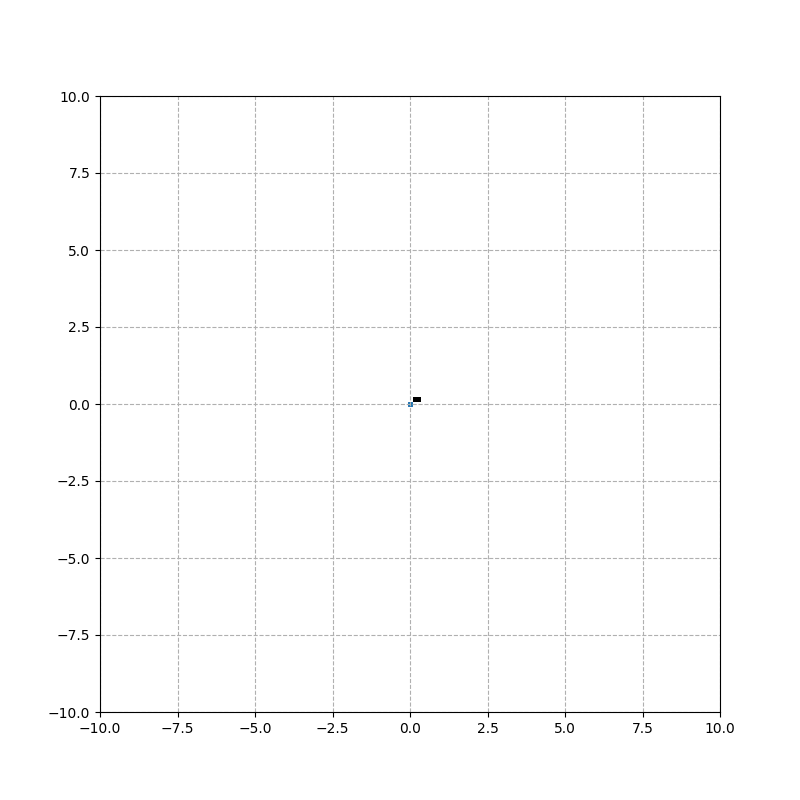

In [6]:
%matplotlib ipympl
ani = plot_simulation(df, method="constant_v")

#### Case 2: Preferred direction (constant v)

In [7]:
N = 100
V = 1
T = 100
LAMBDA = 1
TAU = 1 / LAMBDA
DIRECTION = [np.pi / 6, np.pi / 2]
FRAME_INTERVAL = 0.01 

In [8]:
samples = generate_possion_process(N, rate=LAMBDA, time=T, method="time")
dfs = []
for idx, sample in enumerate(samples):
    initial_direction = np.random.uniform(0, 2 * np.pi, size=1)
    pos = calculate_translation(V, initial_direction + np.cumsum(generate_directions(len(sample))))
    dfs.append(pd.DataFrame({"x": pos[:, 0], "y": pos[:, 1], "id": idx, "t": sample}))
df = pd.concat(dfs).sort_values("id").reset_index(drop=True)

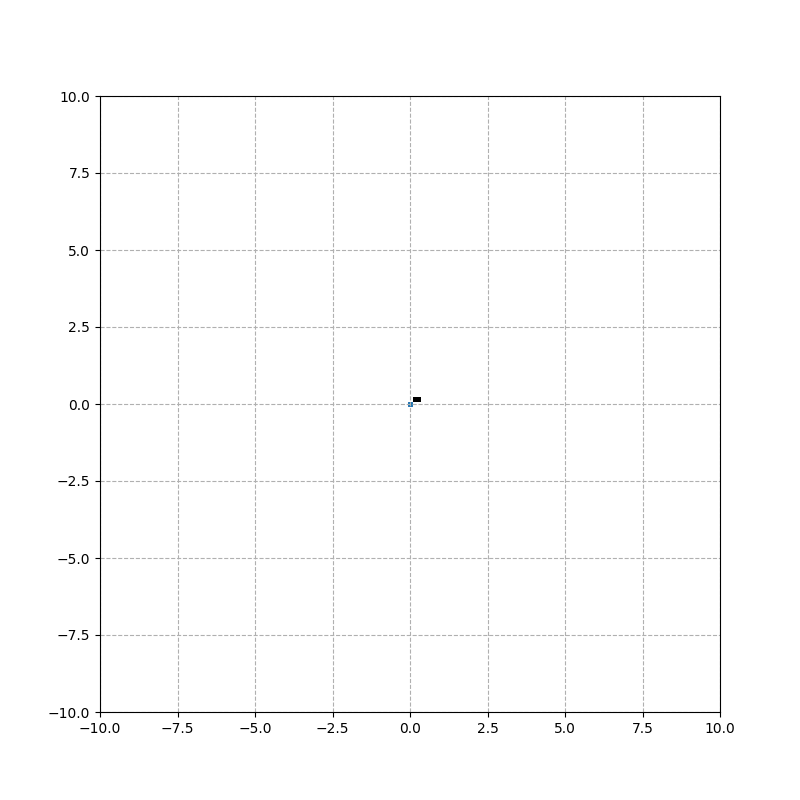

In [9]:
%matplotlib ipympl
ani = plot_simulation(df, method="constant_v")

#### Case 3: Random tumbling (jumping)

In [10]:
N = 100
V = 1
T = 100
LAMBDA = 1
TAU = 1 / LAMBDA
DIRECTION = [0, np.pi * 2]
FRAME_INTERVAL = 0.01 

In [11]:
samples = generate_possion_process(N, rate=LAMBDA, time=T, method="time")
dfs = []
# Random Direction
for idx, sample in enumerate(samples):
    pos = calculate_translation(V, generate_directions(len(sample)))
    dfs.append(pd.DataFrame({"x": pos[:, 0], "y": pos[:, 1], "id": idx, "t": sample}))
df = pd.concat(dfs).sort_values("id").reset_index(drop=True)

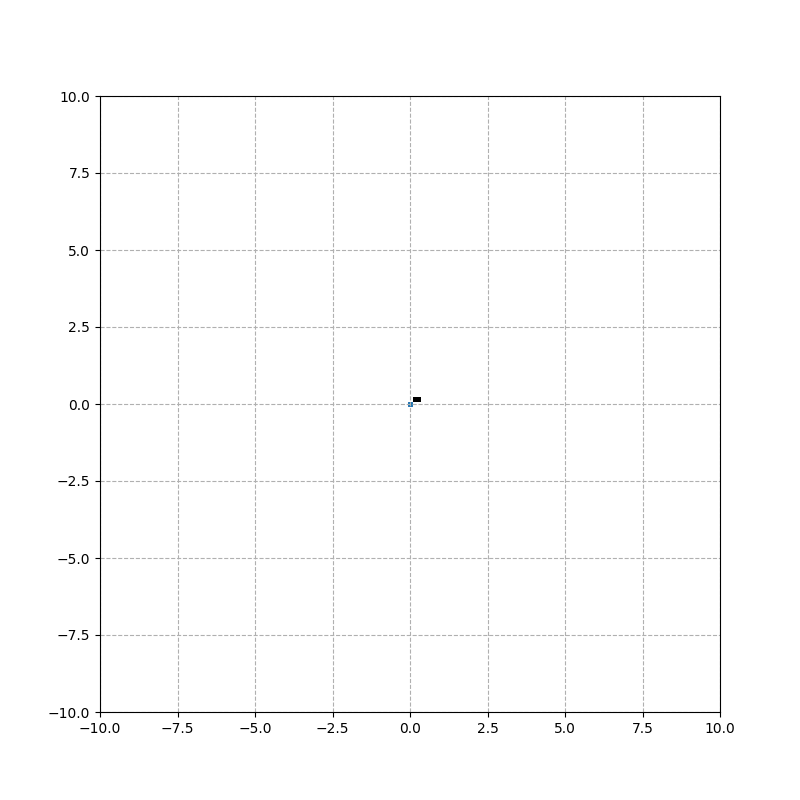

In [12]:
%matplotlib ipympl
ani = plot_simulation(df, method="jump")